In [28]:
%%capture
%pip install pymc
%pip install --upgrade xarray==2022.3.0

# Importing packages
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
from matplotlib.patches import Ellipse
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import SpectralEmbedding
from sklearn.impute import KNNImputer
from statsmodels.distributions.empirical_distribution import ECDF

# Choosing plot style
plt.style.use('fivethirtyeight')

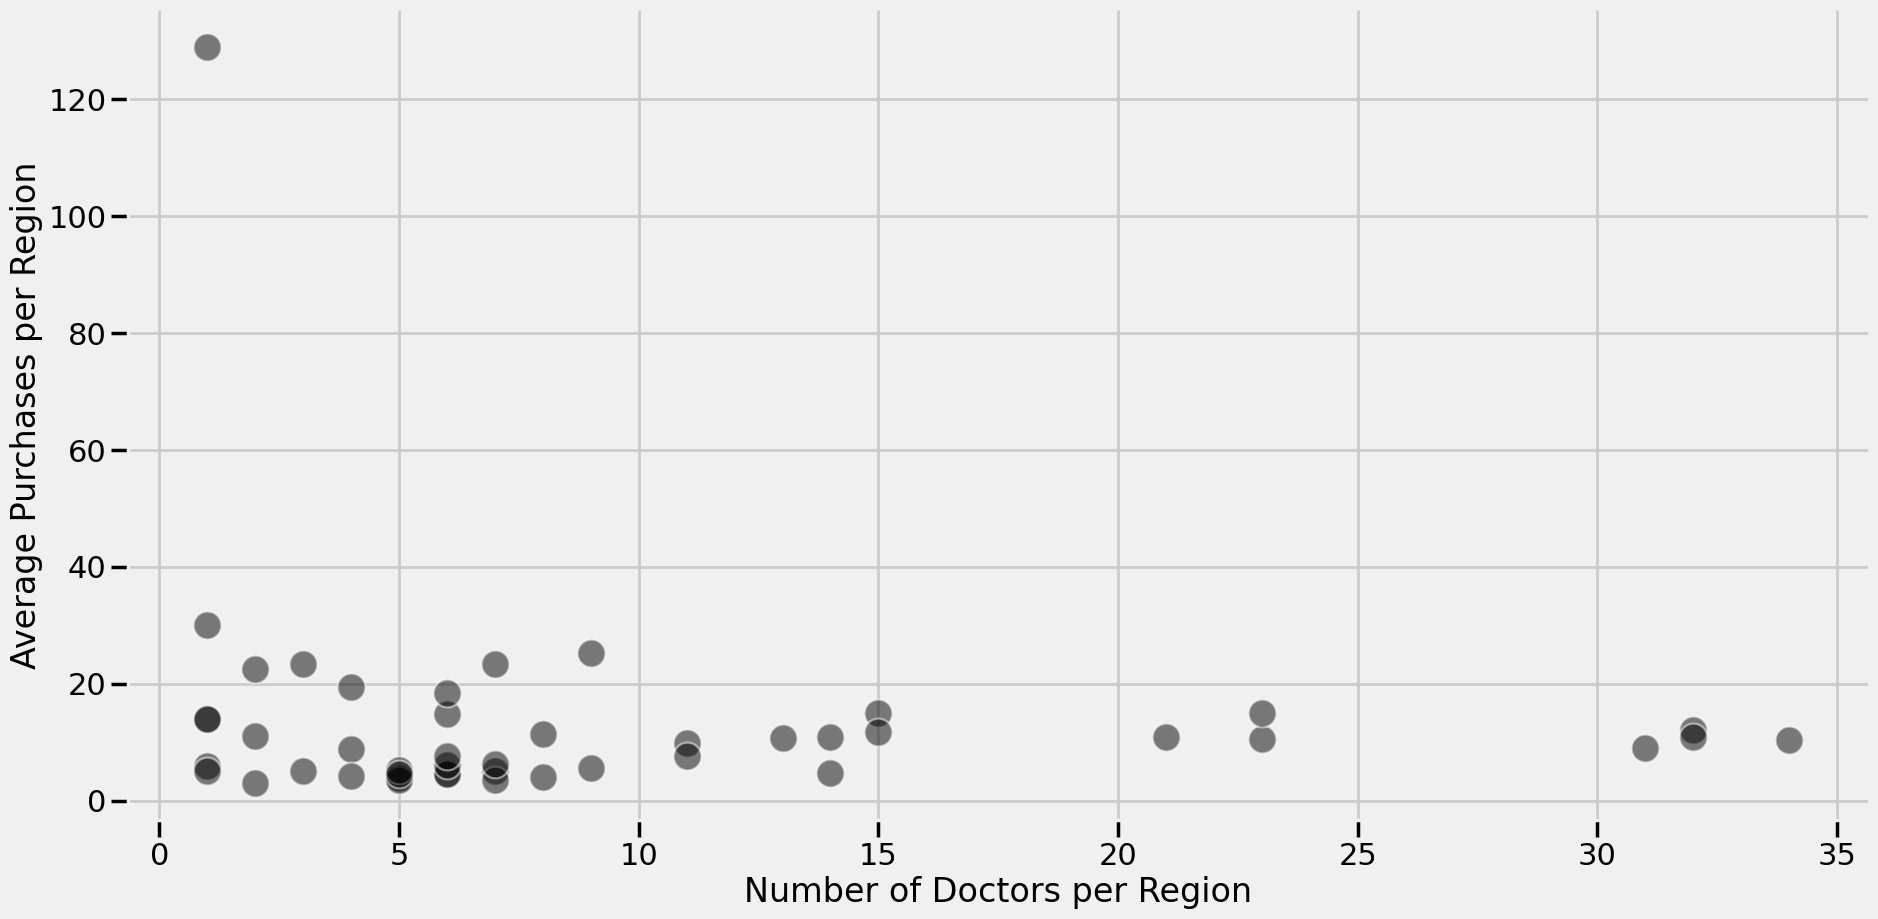

In [38]:
# Loading data needed
doctors = pd.read_csv('data/doctors.csv')
orders = pd.read_csv('data/orders.csv')
complaints = pd.read_csv('data/complaints.csv')
instructions = pd.read_csv('data/instructions.csv')

# Aggregating the doctors dataset
query1 = (doctors
          .groupby(by='Region', as_index=False)
          .agg(number_of_doctors=('DoctorID', pd.Series.nunique),
               average_purchase_number=('Purchases', 'mean'))
          .round(3))

# Making scatterplot of number of doctors per region vs. average purchases per region
with sns.plotting_context('poster'):
    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    sns.despine(fig)
    sns.scatterplot(data=query1, x='number_of_doctors', y='average_purchase_number', 
                    color='black', alpha=0.5, s=400, ax=ax)
    ax.set(ylabel='Average Purchases per Region', xlabel='Number of Doctors per Region')
    

In [30]:
# Feature engineering
# Cleaning doctors dataset
doctors_processed = (doctors
                     .assign(**pd.get_dummies(doctors[['Category', 'Rank']], drop_first=True))
                     .assign(Satisfaction=pd.to_numeric(doctors['Satisfaction'], errors='coerce'))
                     .set_index('DoctorID')
                     .filter(regex='rate|Satisfaction|Experience|Purchases|Rank_|Category_')
                    )

# Cleaning orders dataset, calculating unique-condition-index and the number of unique treatments
orders_processed = (orders
                    .set_index('DoctorID')
                    .filter(regex='Condition [A-I]')
                    .groupby('DoctorID')
                    .apply(lambda x: x.sum(axis='rows'))
                    .gt(0)
                    .sum(axis='columns')
                    .to_frame('Unique Condition Index')
                   )

# Cleaning complaints dataset, counting the total number of complaints a doctor gives across complaint types
complaints_processed = (complaints
                        .groupby('DoctorID')
                        .agg(Complaints=('Qty', 'sum'))
                       )

# Merging the data and scaling appropriate variables
z_score_these = ['Incidence rate', 'R rate', 'Satisfaction', 
                 'Experience', 'Complaints', 'Unique Condition Index']

# Merging the data together
df = (complaints_processed
      .join(doctors_processed, how='inner')
      .join(orders_processed, how='left')
     )

# Imputing the missing data in Satisfaction with KNN
imputed_data = KNNImputer(n_neighbors=4).fit_transform(df)

# Creating a dataframe and scaling again
df = pd.DataFrame(imputed_data, index=df.index, columns=df.columns).apply(lambda z: st.zscore(z) if z.name in z_score_these else z)

In [31]:
# Testing association using a PyMC negative binomial regression model
X = df.drop(columns='Purchases')
y = df['Purchases'].values

with pm.Model(coords={'coefs': X.columns}) as bayesian_negbinom_regression:
    β0 = pm.Normal('β0', mu=0, sigma=1)
    β = pm.Normal('β', mu=0, sigma=1, dims='coefs')
    λ = β0 + pm.math.dot(X.values, β)
    λ_exp = pm.Deterministic('λ_exp', pm.math.exp(λ))
    α = pm.Exponential('nb', 0.01)
    pm.NegativeBinomial('likelihood', mu=λ_exp, alpha=α, observed=y)
    trace = pm.sample(2000, tune=2000, target_accept=.90, random_seed=42)

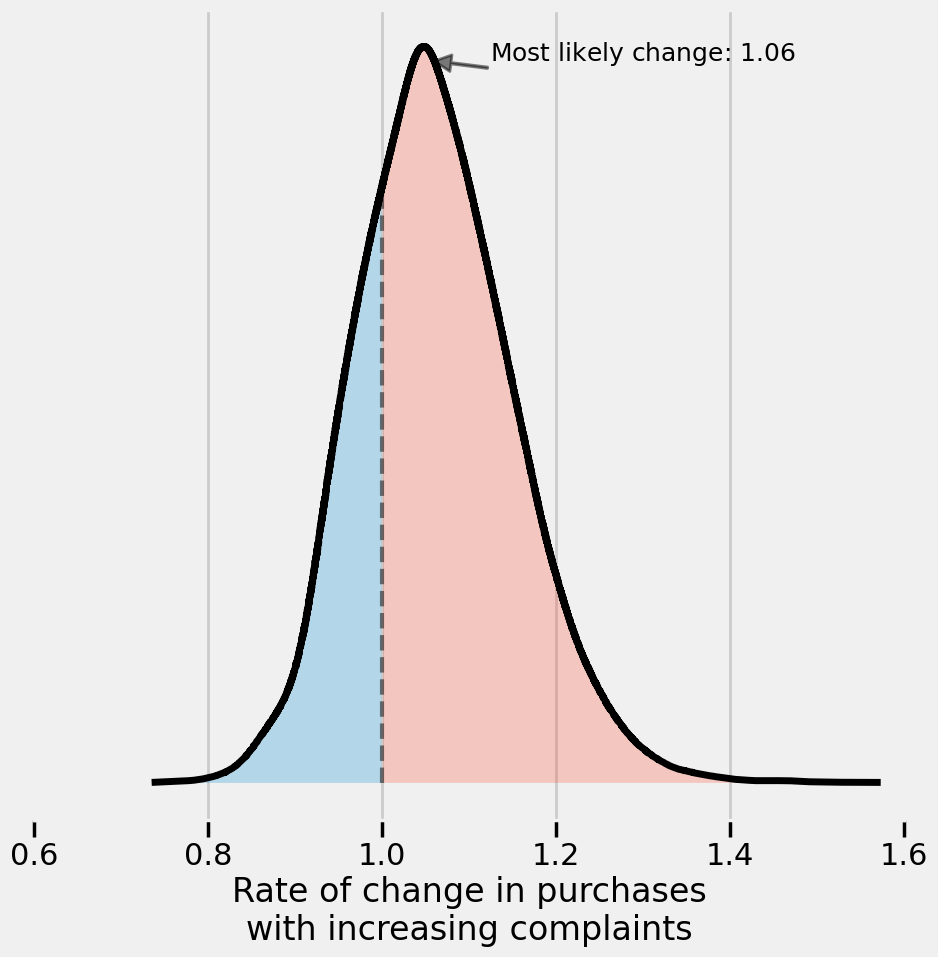

In [32]:
# Extracting posterior distribution of the "complaints" predictor and taking its empirical cumulative distribution and survival function
coef_trace = np.exp(trace['posterior'].sel(coefs='Complaints')['β'].values.flatten())
ecdf = ECDF(coef_trace)([coef_trace]).ravel()
esf = 1 - ecdf

# Building a kernel density estimate and its probability density function of the coefficient
density = st.gaussian_kde(coef_trace)
kde = density.pdf(coef_trace)

# Storing as a dataframe and plotting it
traceplot = pd.DataFrame({'trace': coef_trace, 'density': kde, 'ecdf': ecdf, 'esf': esf}).round(3).sort_values(by='trace')

with sns.plotting_context('poster'):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.plot('trace', 'density', data=traceplot, lw=5, color='black')
    ax.plot([1, 1], [0, density.pdf(1)], color='black', alpha=.5, linestyle='dashed')
    ax.set(xlim=(0.6, 1.6), yticks=[], xlabel='Rate of change in purchases\nwith increasing complaints')
    ax.fill_between('trace', 'density', where=traceplot['trace'].lt(1).values, data=traceplot, alpha=.25)
    ax.fill_between('trace', 'density', where=traceplot['trace'].gt(1).values, data=traceplot, alpha=.25)
    ax.annotate('Most likely change: $1.06$',
                (1.06, 4.5), (1.30, 4.5), arrowprops={'width': 1, 'color': 'black', 'alpha': .5},
                fontsize=18, horizontalalignment='center')

In [33]:
# Scaling Qty measure and using spectral embedding to preserve local distances
df = df.assign(Purchases=st.zscore(df['Purchases']))
spectra = SpectralEmbedding(n_components=2, random_state=42).fit_transform(df)

# Using silhouette scoring to select K with K-means
sc = {}
for k in range(2, 10):
    km = KMeans(n_clusters=k, random_state=42).fit(spectra)
    sc[k] = silhouette_score(spectra, km.labels_)
best_K, best_sc = max(sc.items(), key=lambda y: y[-1])
final_k = KMeans(n_clusters=best_K, random_state=42).fit(spectra)

# Revealing dimension reduction and clusters in an interactive plot
spectra_df = (pd.DataFrame(spectra, columns=['spec_1', 'spec_2'], index=df.index)
              .assign(Segment=final_k.labels_+1)
              .join(doctors[['DoctorID', 'Category', 'Rank', 'Region']].set_index('DoctorID'))
              .join(df)
              .reset_index()
             )

# Taking mean of continuous features and count of Category/Rank for each group
average = ['Complaints', 'Incidence rate', 'R rate', 'Satisfaction', 'Experience', 'Purchases', 'Unique Condition Index']

# Computing means and counts of continuous and categorical features in each segment
base = spectra_df.groupby('Segment')
chart = (base.agg({x: 'mean' for x in average})
         .join(base['Category'].value_counts().unstack('Category'))
         .join(base['Rank'].value_counts().unstack('Rank'))
         .fillna(0)
         .reset_index()
         .melt(id_vars='Segment', var_name='Attribute', value_name='Aggregate')
         .assign(prep=lambda x: np.where(x['Attribute'].isin(average), 'con', 'cat'))
        )

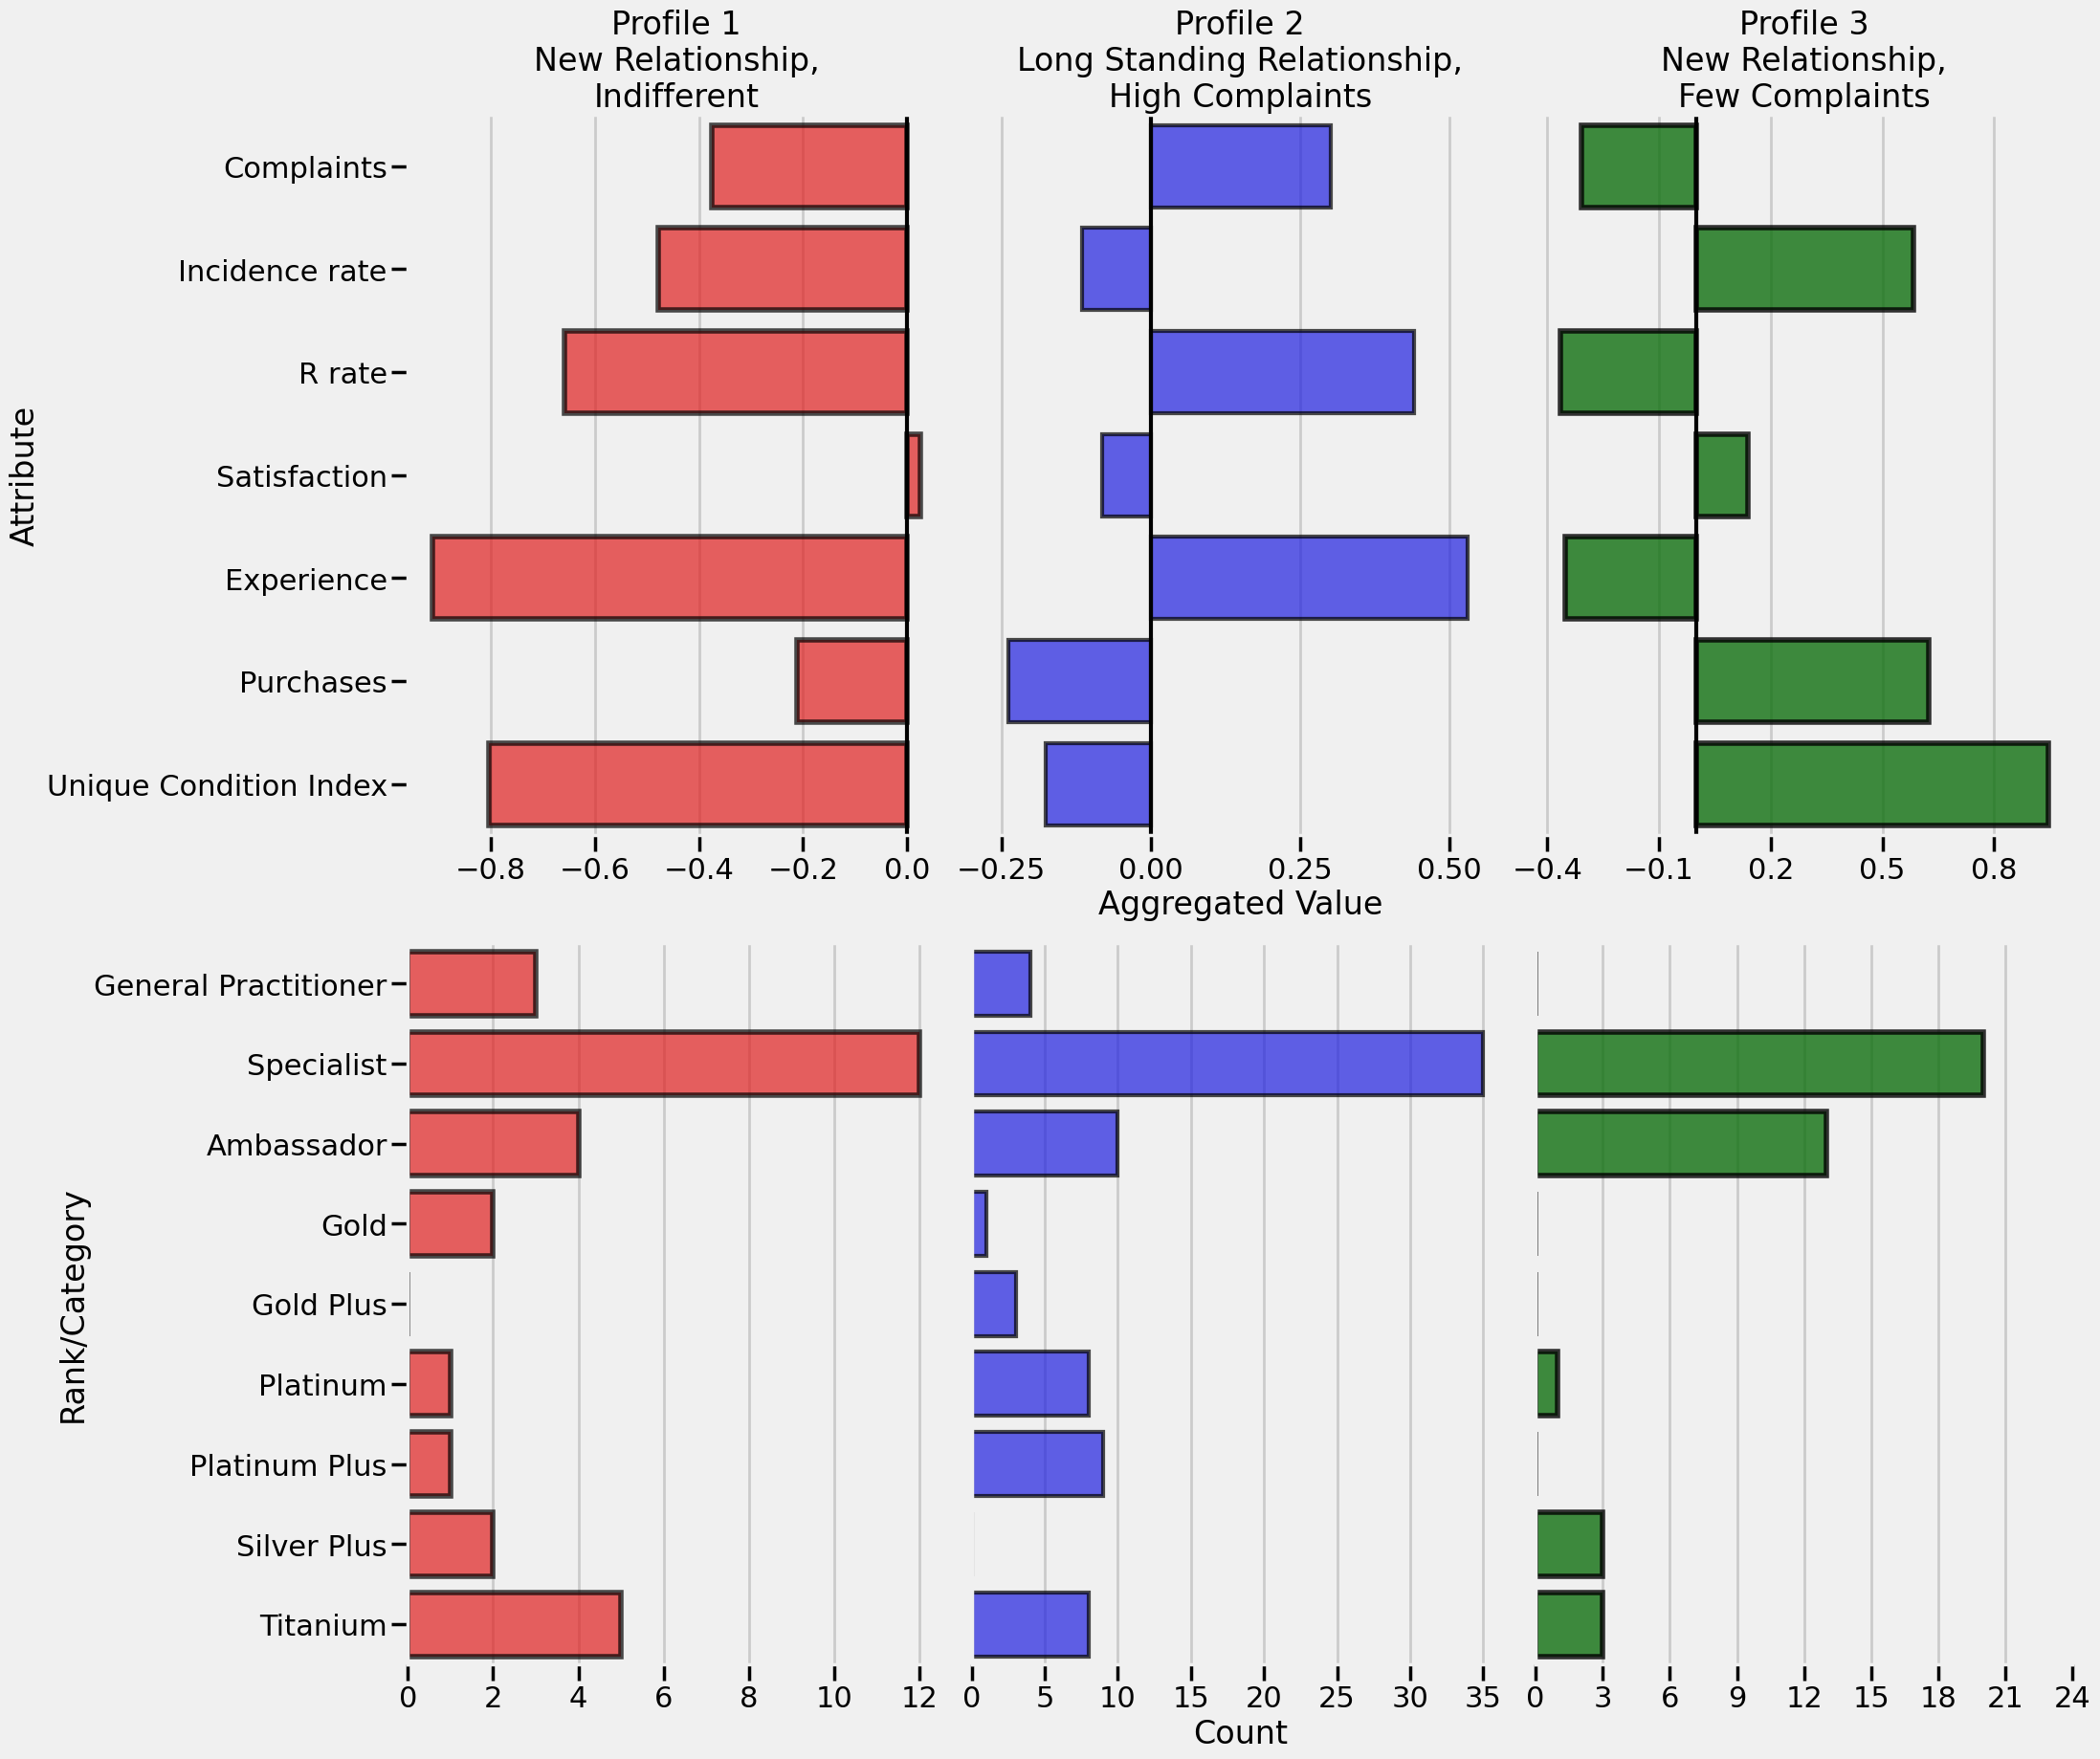

In [34]:
# Visualizing cluster profiles
with sns.plotting_context('poster'):
    fig, (continuous, categories) = plt.subplots(2, 3, figsize=(20, 20), gridspec_kw={'wspace': 0.05, 'hspace': 0.15})
    con, cat = chart.query('prep == "con"'), chart.query('prep == "cat"')
    plot_profiles = {1: {'edgecolor': 'black', 'linewidth': 4, 'color': 'red', 'alpha': .7},
                     2: {'edgecolor': 'black', 'linewidth': 3, 'color': 'blue', 'alpha': .7},
                     3: {'edgecolor': 'black', 'linewidth': 4, 'color': 'green', 'alpha': .8}
                    }
    for ax, (cl, seg) in zip(continuous, con.groupby('Segment')):
        sns.barplot(data=seg, x='Aggregate', y='Attribute', ax=ax, **plot_profiles[cl])
        ax.axvline(0, color='black', alpha=1)
        if cl in [2, 3]: ax.set(yticks=[], ylabel='')
        ax.set(xlabel='') if cl != 2 else ax.set(xlabel='Aggregated Value')
    for ax, (cl, seg) in zip(categories, cat.groupby('Segment')):
        sns.barplot(data=seg, x='Aggregate', y='Attribute', ax=ax, **plot_profiles[cl])
        if cl in [2, 3]: ax.set(yticks=[], ylabel='') 
        ax.set(xlabel='') if cl != 2 else ax.set(xlabel='Count')
    categories[0].set(ylabel='Rank/Category')
    continuous[1].set(xlim=(-0.3, 0.6), xticks=[-0.25, 0, 0.25, 0.5])
    continuous[2].set(xticks=np.arange(-0.4, 1, 0.3))
    categories[2].set(xticks=np.arange(0, 25, 3))
    seg_titles = {1: 'Profile 1\nNew Relationship,\nIndifferent',
                  2: 'Profile 2\nLong Standing Relationship,\nHigh Complaints',
                  3: 'Profile 3\nNew Relationship,\nFew Complaints'}
    for k, t in seg_titles.items():
        continuous[k-1].set_title(t)

In [35]:
# Determining overall proportions of each segment
spectra_df['Segment'].value_counts(normalize=True).sort_index().round(2).to_frame('Proportion of sample').rename_axis(index='Segment Number')

,Proportion of sample
Segment Number,
1,0.20
2,0.53
3,0.27


In [36]:
# Showing results in a table
(az
 .summary(trace, var_names='β', 
          filter_vars='like', 
          kind='stats', 
          hdi_prob=.95,
          stat_funcs={'Purchase Rate Change': lambda x: np.mean(np.exp(x)),
                      '95% lower': lambda x: az.hdi(np.exp(x), .95)[0],
                      '95% upper': lambda x: az.hdi(np.exp(x), .95)[1],
                      'Probability Positive': lambda x: np.mean(np.exp(x) > 1)})
 .drop(index=['β0'])
 .assign(Feature=lambda x: x.index.str.replace('β|\\[|\\]', '', regex=True).str.replace('_', ': '))
 .set_index('Feature')
 .filter(items=['Purchase Rate Change', '95% lower', '95% upper', 'Probability Positive'])
 .style
 .applymap(lambda x: 'color: blue' if x < .20 or x > .80 else None, subset=['Probability Positive'])
 .format('{:.2f}')
)

,Purchase Rate Change,95% lower,95% upper,Probability Positive
Feature,,,,
Complaints,1.06,0.89,1.25,0.75
Incidence rate,1.09,0.91,1.25,0.84
R rate,1.03,0.84,1.26,0.61
Satisfaction,1.08,0.89,1.25,0.80
Experience,1.15,0.95,1.36,0.93
Category: Specialist,2.29,1.00,3.85,0.99
Rank: Gold,0.38,0.10,0.81,0.02
Rank: Gold Plus,0.21,0.05,0.44,0.00
Rank: Platinum,0.30,0.15,0.46,0.00


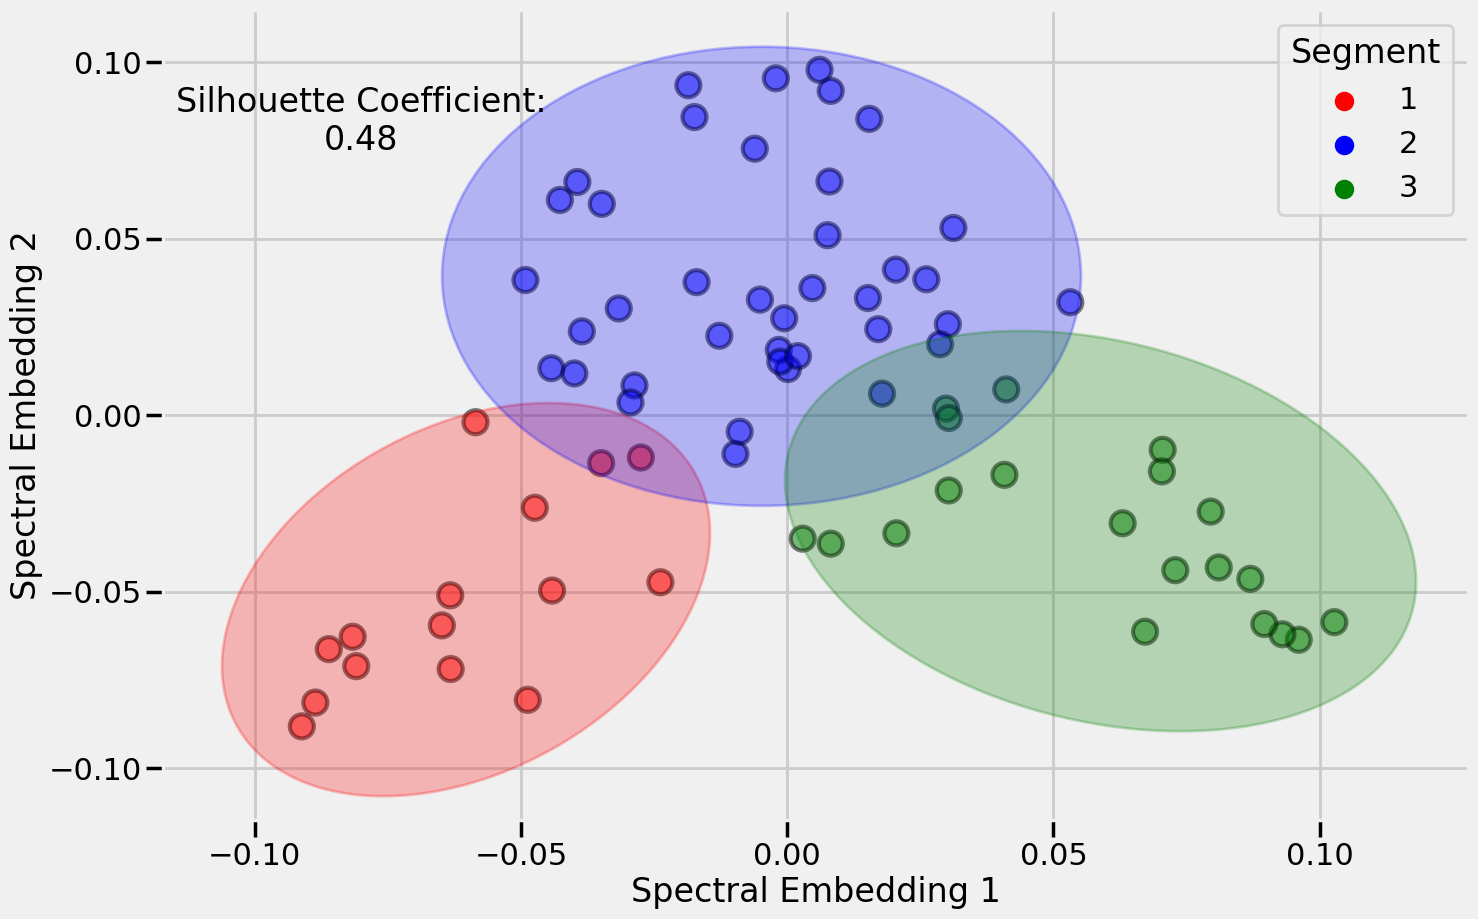

In [37]:
# Plotting spectral embedding
with sns.plotting_context('poster'):
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    sns.scatterplot(data=spectra_df, x='spec_1', y='spec_2', hue='Segment', palette=['red', 'blue', 'green'], 
                    s=300, alpha=.5, edgecolor='black', linewidth=3)
    ax.set(ylabel='Spectral Embedding 2', xlabel='Spectral Embedding 1')
    ellipse_params = {1: {'width': 0.08, 'height': 0.12, 'angle': 150., 'color': 'red', 'alpha': .25},
                      2: {'width': 0.12, 'height': 0.13, 'angle': 0., 'color': 'blue', 'alpha': .25},
                      3: {'width': 0.10, 'height': 0.13, 'angle': 50., 'color': 'green', 'alpha': .25}}
    ax.annotate(f'Silhouette Coefficient:\n{best_sc:.2f}', (-0.08, 0.075), horizontalalignment='center')
    for index, params in ellipse_params.items():
        ellipse = Ellipse(xy=tuple(final_k.cluster_centers_[index-1, :]), **params)
        ax.add_patch(ellipse)